# Prediction Models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import pointbiserialr

m=pd.read_csv("data/Morningstar - European Mutual Funds.csv")

# Assuming df is your DataFrame
threshold = 0.3  # Set the threshold for missing values (30%)

# Calculate the percentage of missing values in each column
missing_percentages = m.isnull().mean()

# Identify columns with missing values exceeding the threshold
columns_to_drop = missing_percentages[missing_percentages > threshold].index

# Drop columns with more than 30% missing values
df = m.drop(columns=columns_to_drop)

# Alternatively, you can modify the original DataFrame in place
# df.drop(columns=columns_to_drop, inplace=True)

# Display the resulting DataFrame
#print(df)

#print(df.columns)


numerical_cols = df.select_dtypes(include=['number']).columns

# Iterate through each numerical column
for col in numerical_cols:
    # Check if there are missing values in the column
    if df[col].isnull().any():
        # Calculate mean and median
        mean_val = df[col].mean()
        median_val = df[col].median()
        
        # Determine whether to impute with mean or median
        if abs(mean_val - median_val) < 0.5:  # Adjust the threshold as needed
            imputation_value = mean_val
            imputation_method = 'mean'
        else:
            imputation_value = median_val
            imputation_method = 'median'
        
        # Impute missing values with either mean or median
        df[col].fillna(imputation_value, inplace=True)
        
        print(f"Imputed missing values in '{col}' with {imputation_method} ({imputation_value:.3f}).")

# Display the DataFrame with imputed values
print(df)
    

print(len(df.select_dtypes(include=['object']).columns))
print(len(df.select_dtypes(include=['float64', 'int64']).columns))


categorical_cols = df.select_dtypes(include=['object']).columns

# Impute missing values with mode for each categorical column
for col in categorical_cols:
    mode_value = df[col].mode()[0]  # Mode may have multiple values, so we take the first one
    df[col].fillna(mode_value, inplace=True)
    
print(df.isnull().sum().sum())

Imputed missing values in 'ongoing_cost' with mean (1.124).
Imputed missing values in 'management_fees' with mean (0.840).
Imputed missing values in 'involvement_abortive_contraceptive' with median (3.420).
Imputed missing values in 'involvement_alcohol' with median (0.040).
Imputed missing values in 'involvement_animal_testing' with median (7.610).
Imputed missing values in 'involvement_controversial_weapons' with mean (0.460).
Imputed missing values in 'involvement_gambling' with median (0.000).
Imputed missing values in 'involvement_gmo' with mean (0.045).
Imputed missing values in 'involvement_military_contracting' with median (0.060).
Imputed missing values in 'involvement_nuclear' with median (0.070).
Imputed missing values in 'involvement_palm_oil' with mean (0.058).
Imputed missing values in 'involvement_pesticides' with mean (0.297).
Imputed missing values in 'involvement_small_arms' with mean (0.306).
Imputed missing values in 'involvement_thermal_coal' with median (0.740).
I

0


# EDA on the select columns

In [2]:
# Calculating descriptive statistics for 'fund_return_2019' and relevant numerical independent variables

descriptive_stats_columns = ['fund_return_2019', 'asset_stock', 'asset_bond', 'asset_cash']

# Check if the relevant columns exist in the DataFrame
if all(column in df.columns for column in descriptive_stats_columns):
    # Calculating descriptive statistics
    descriptive_stats = df[descriptive_stats_columns].describe()
else:
    descriptive_stats = "Some specified columns are missing from the DataFrame."

descriptive_stats


,fund_return_2019,asset_stock,asset_bond,asset_cash
count,57603.000000,57603.000000,57603.000000,57603.000000
mean,11.825853,51.649886,36.360552,7.054352
std,8.927562,45.461402,44.588377,22.678448
min,-36.090000,-34.760000,-747.960000,-515.100000
25%,5.790000,0.000000,0.000000,0.790000
50%,11.140000,59.980000,4.220000,2.700000
75%,17.500000,97.820000,87.660000,6.570000
max,51.960000,326.810000,582.820000,845.600000


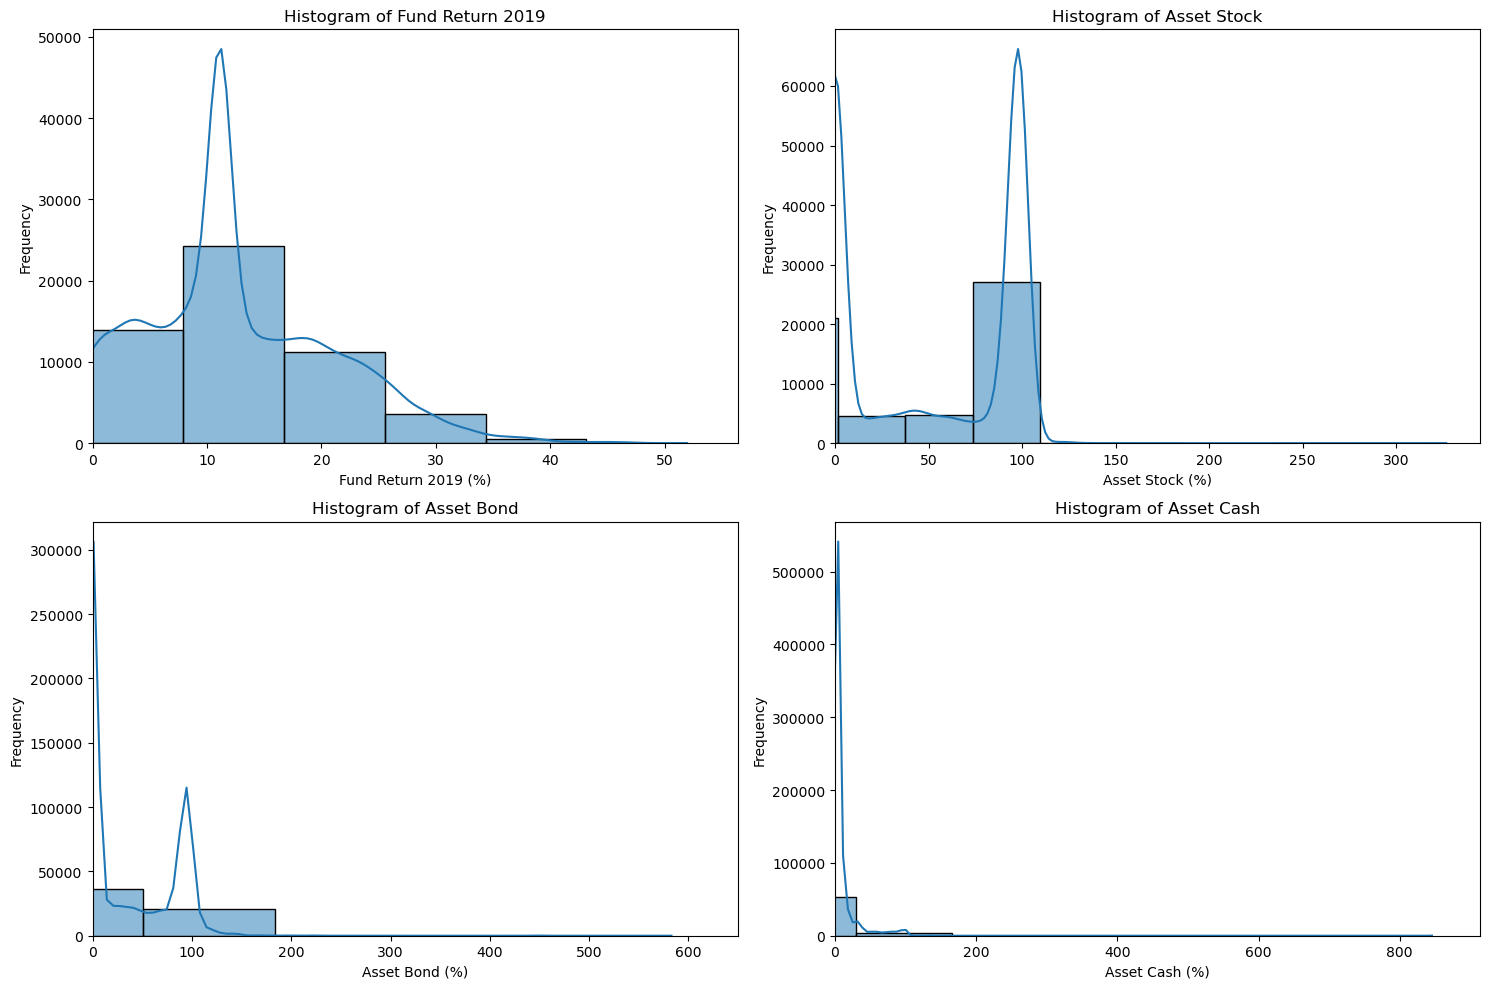

In [4]:
# Adjusting the histograms to start from 0

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Histogram for 'fund_return_2019'
sns.histplot(df['fund_return_2019'], bins=10, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram of Fund Return 2019')
axes[0, 0].set_xlabel('Fund Return 2019 (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xlim(left=0)  # Setting the x-axis to start from 0

# Histogram for 'asset_stock'
sns.histplot(df['asset_stock'], bins=10, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Asset Stock')
axes[0, 1].set_xlabel('Asset Stock (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_xlim(left=0)  # Setting the x-axis to start from 0

# Histogram for 'asset_bond'
sns.histplot(df['asset_bond'], bins=10, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Histogram of Asset Bond')
axes[1, 0].set_xlabel('Asset Bond (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(left=0)  # Setting the x-axis to start from 0

# Histogram for 'asset_cash'
sns.histplot(df['asset_cash'], bins=10, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Histogram of Asset Cash')
axes[1, 1].set_xlabel('Asset Cash (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_xlim(left=0)  # Setting the x-axis to start from 0

plt.tight_layout()
plt.show()


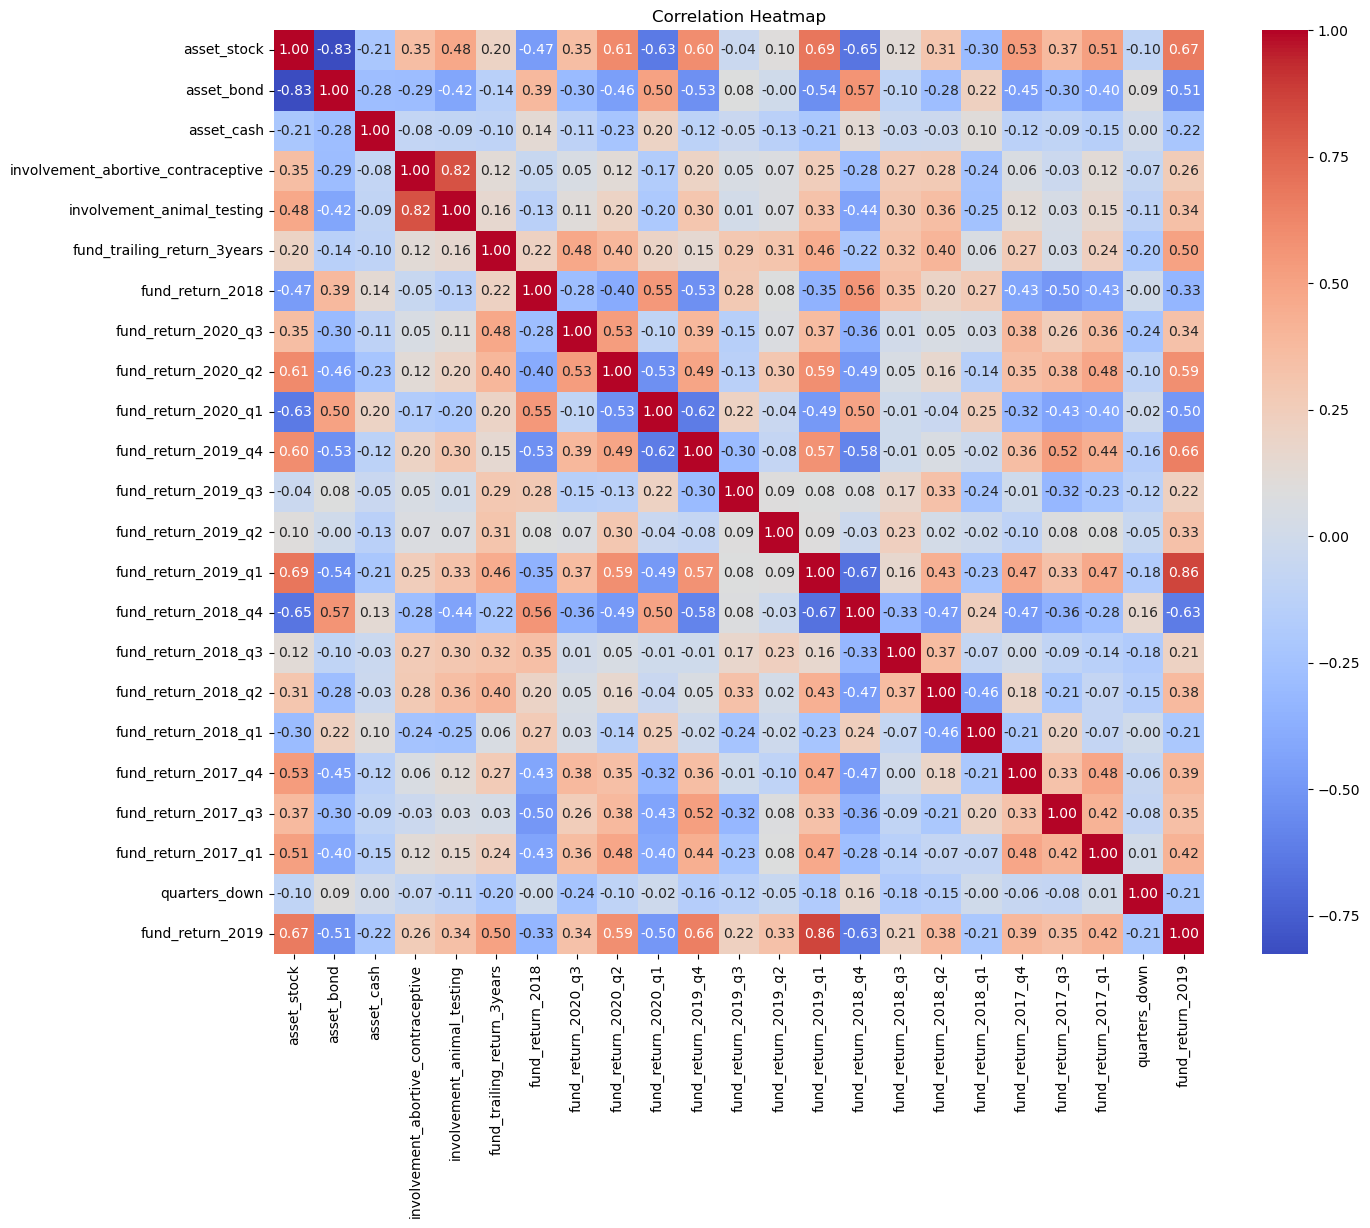

In [5]:
# Correlation analysis of 'fund_return_2019' with other numerical variables

numerical_columns = [
    'asset_stock', 'asset_bond', 'asset_cash', 
    'involvement_abortive_contraceptive', 'involvement_animal_testing', 
    'fund_trailing_return_3years', 'fund_return_2018', 'fund_return_2020_q3', 
    'fund_return_2020_q2', 'fund_return_2020_q1', 'fund_return_2019_q4', 
    'fund_return_2019_q3', 'fund_return_2019_q2', 'fund_return_2019_q1', 
    'fund_return_2018_q4', 'fund_return_2018_q3', 'fund_return_2018_q2', 
    'fund_return_2018_q1', 'fund_return_2017_q4', 'fund_return_2017_q3', 
    'fund_return_2017_q1', 'quarters_down', 'fund_return_2019'
]

# Check if all specified columns are present in the DataFrame
if all(column in df.columns for column in numerical_columns):
    # Computing the correlation matrix
    correlation_matrix = df[numerical_columns].corr()

    # Creating a heatmap for visualization
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
else:
    plt.text(0.5, 0.5, 'Some specified columns are missing from the DataFrame.', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Data Unavailable')
    plt.show()


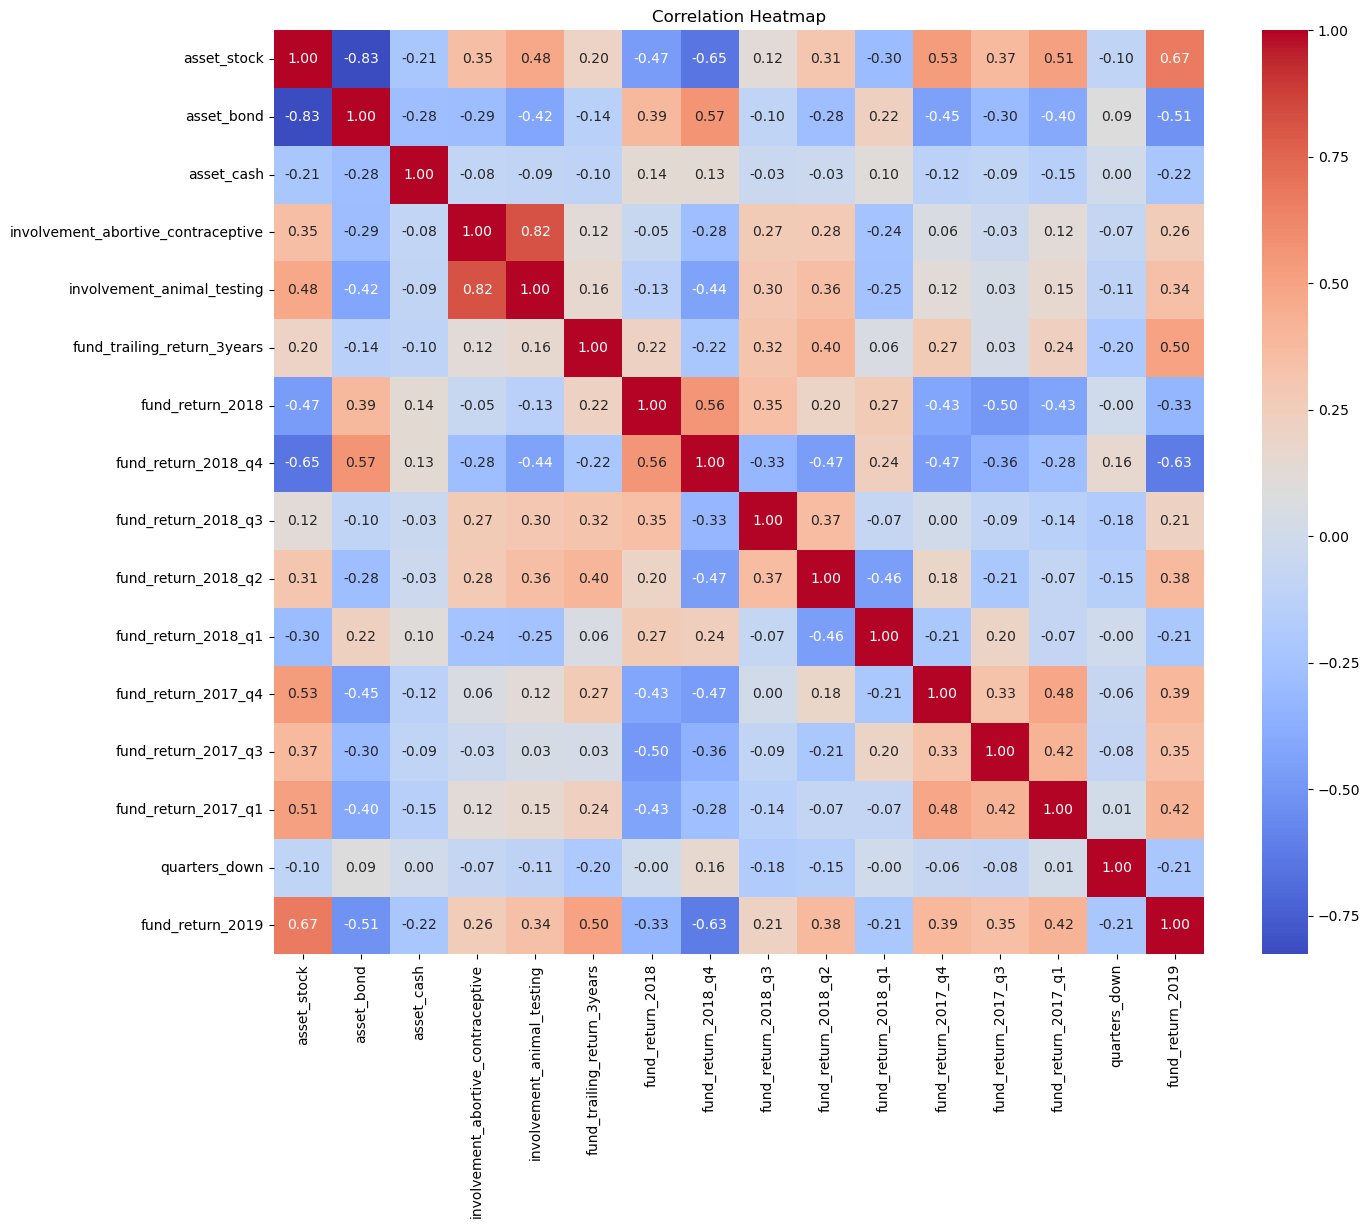

In [9]:
numerical_columns = [
    'asset_stock', 'asset_bond', 'asset_cash', 
    'involvement_abortive_contraceptive', 'involvement_animal_testing', 
    'fund_trailing_return_3years', 'fund_return_2018', 
    'fund_return_2018_q4', 'fund_return_2018_q3', 'fund_return_2018_q2', 
    'fund_return_2018_q1', 'fund_return_2017_q4', 'fund_return_2017_q3', 
    'fund_return_2017_q1', 'quarters_down', 'fund_return_2019',
]

# Check if all specified columns are present in the DataFrame
if all(column in df.columns for column in numerical_columns):
    # Computing the correlation matrix
    correlation_matrix = df[numerical_columns].corr()

    # Creating a heatmap for visualization
    plt.figure(figsize=(15, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
else:
    plt.text(0.5, 0.5, 'Some specified columns are missing from the DataFrame.', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Data Unavailable')
    plt.show()

In [ ]:
m=pd.read_csv("data/Morningstar - European Mutual Funds.csv")

#### analyze the trend over time for 'fund_return_2019'.
Line plots showing the trend of returns over different quarters and years could be insightful.

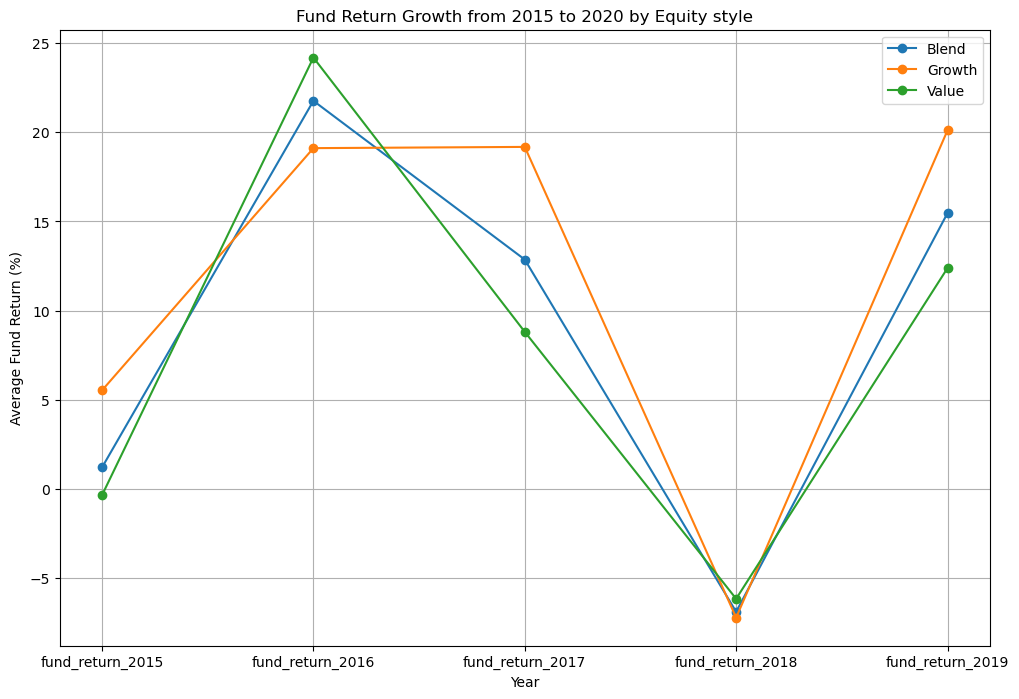

In [11]:
# Analyzing the funds return growth from 2015 to 2020 for different equity sizes

# Assuming the relevant columns for yearly returns are 'fund_return_2015', ..., 'fund_return_2020'
# and 'equity_size' indicates the equity size of the fund

# Check if the relevant columns exist
year_columns = ['fund_return_2015', 'fund_return_2016', 'fund_return_2017', 
                'fund_return_2018', 'fund_return_2019']

if 'equity_style' in m.columns and all(year in m.columns for year in year_columns):
    # Grouping by equity size and calculating the average return for each year
    avg_return_by_equity_size = m.groupby('equity_style')[year_columns].mean()

    # Plotting the line graph
    plt.figure(figsize=(12, 8))
    for equity_size in avg_return_by_equity_size.index:
        plt.plot(avg_return_by_equity_size.columns, avg_return_by_equity_size.loc[equity_size, :], 
                 marker='o', label=equity_size)

    plt.xlabel('Year')
    plt.ylabel('Average Fund Return (%)')
    plt.title('Fund Return Growth from 2015 to 2020 by Equity style')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    plt.text(0.5, 0.5, 'Some specified columns are missing from the DataFrame.', 
             horizontalalignment='center', verticalalignment='center')
    plt.title('Data Unavailable')
    plt.show()



## Categorical Variables Analysis:

Use box plots  to compare the 'fund_return_2019' across different categories of 'category',
Analyze how the returns vary across different fund benchmarks, morningstar benchmarks, and investment managers.

In [16]:
# Creating box plots to compare 'fund_return_2019' across different categorical variables

# Selecting a few categorical columns for the analysis
categorical_columns = ['category', 'fund_benchmark', 'morningstar_benchmark']


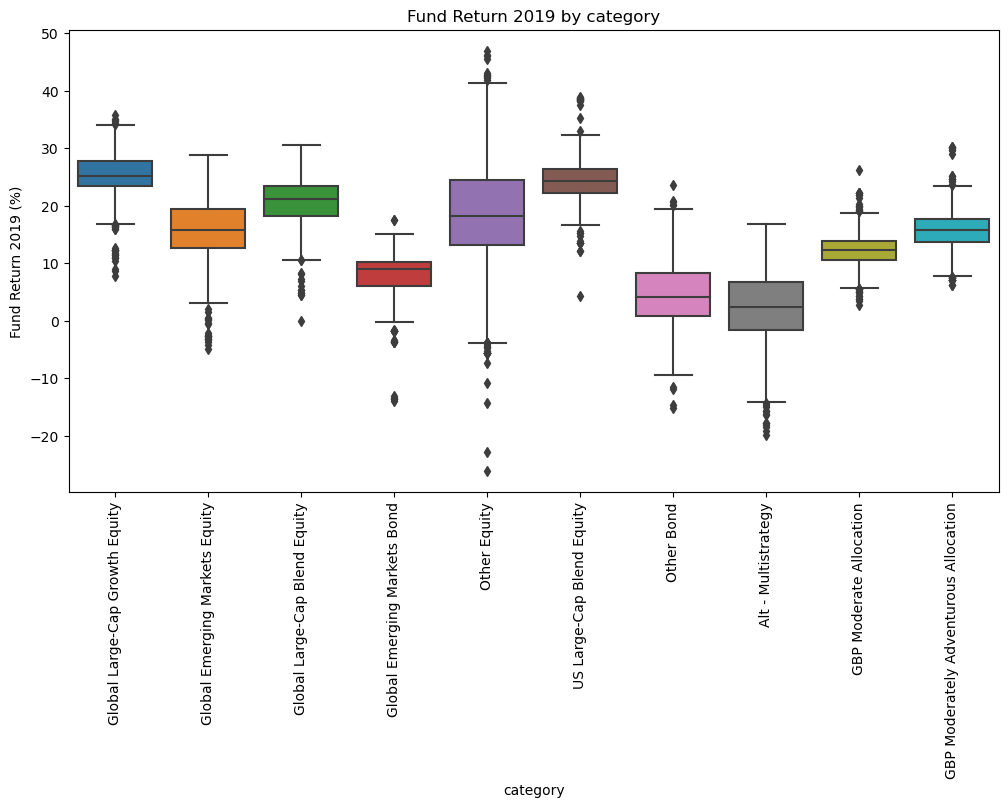

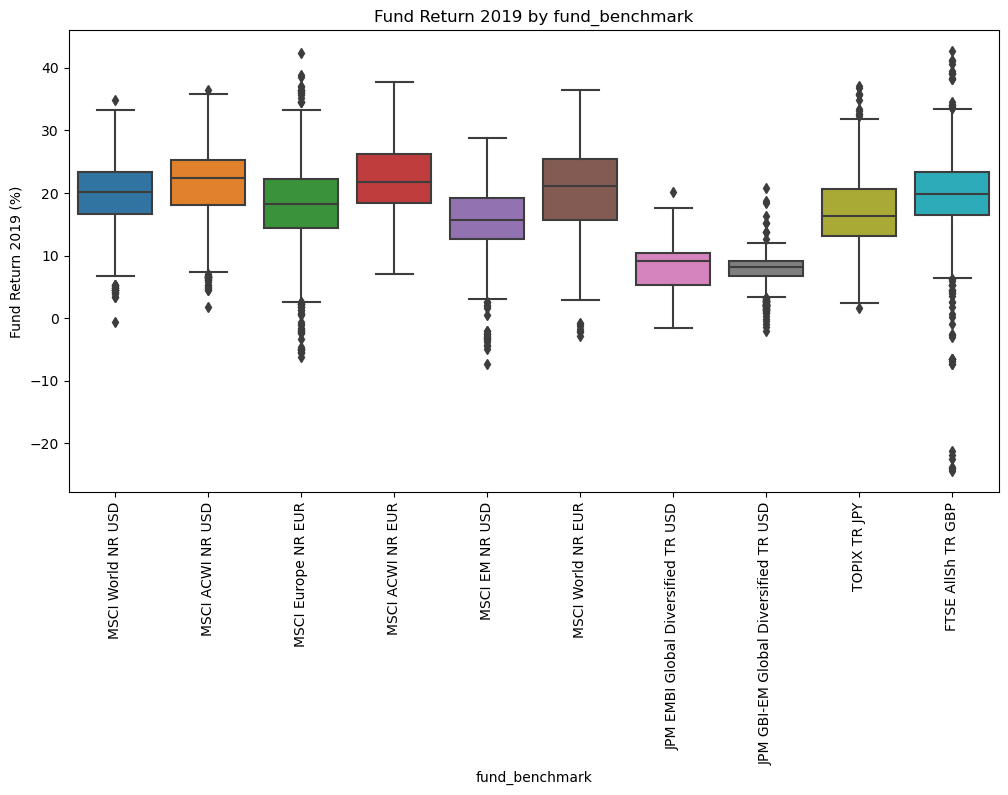

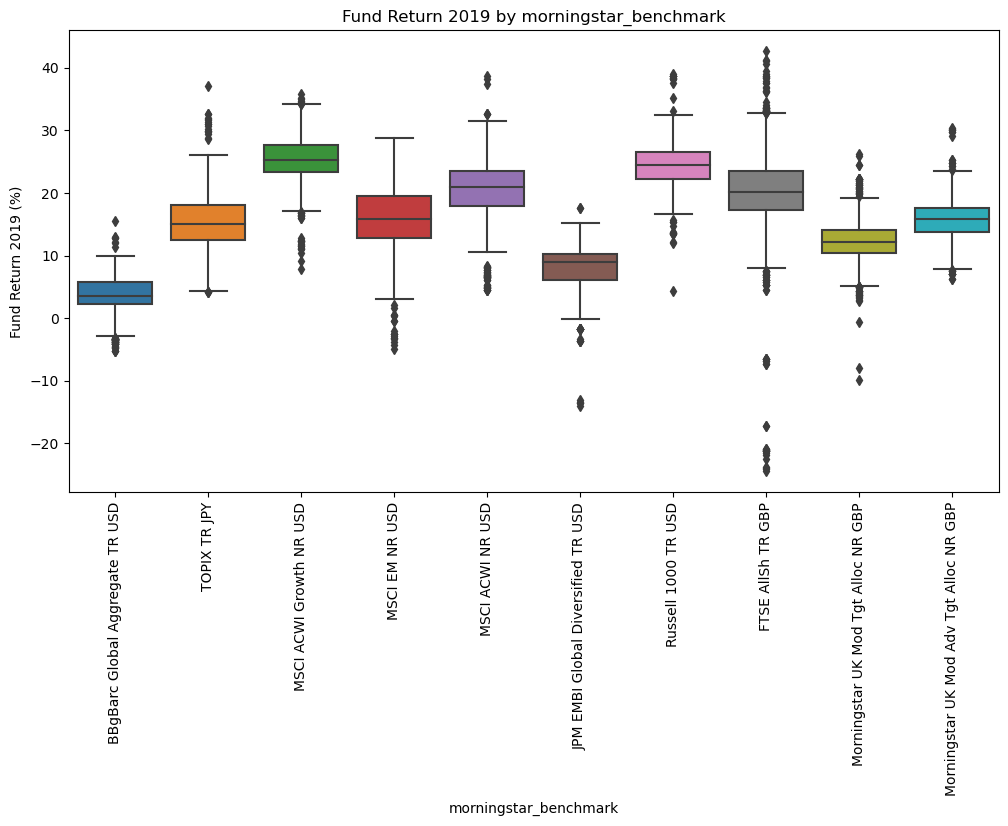

In [17]:
# Creating separate box plots for each categorical variable
# Focusing on a manageable number of categories for each variable

def plot_categorical_analysis(df, column, top_n=10):
    """Plot box plots for the top N categories in a given column."""
    top_categories = df[column].value_counts().head(top_n).index
    filtered_df = df[df[column].isin(top_categories)]
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=column, y='fund_return_2019', data=filtered_df)
    plt.title(f'Fund Return 2019 by {column}')
    plt.xlabel(column)
    plt.ylabel('Fund Return 2019 (%)')
    plt.xticks(rotation=90)
    plt.show()

# Plotting for each categorical column
for col in categorical_columns:
    plot_categorical_analysis(m, col)


## Asset Allocation Analysis:

Investigate how different asset allocations (stocks, bonds, cash) impact the 'fund_return_2019'. Scatter plots or grouped bar plots can be helpful here.

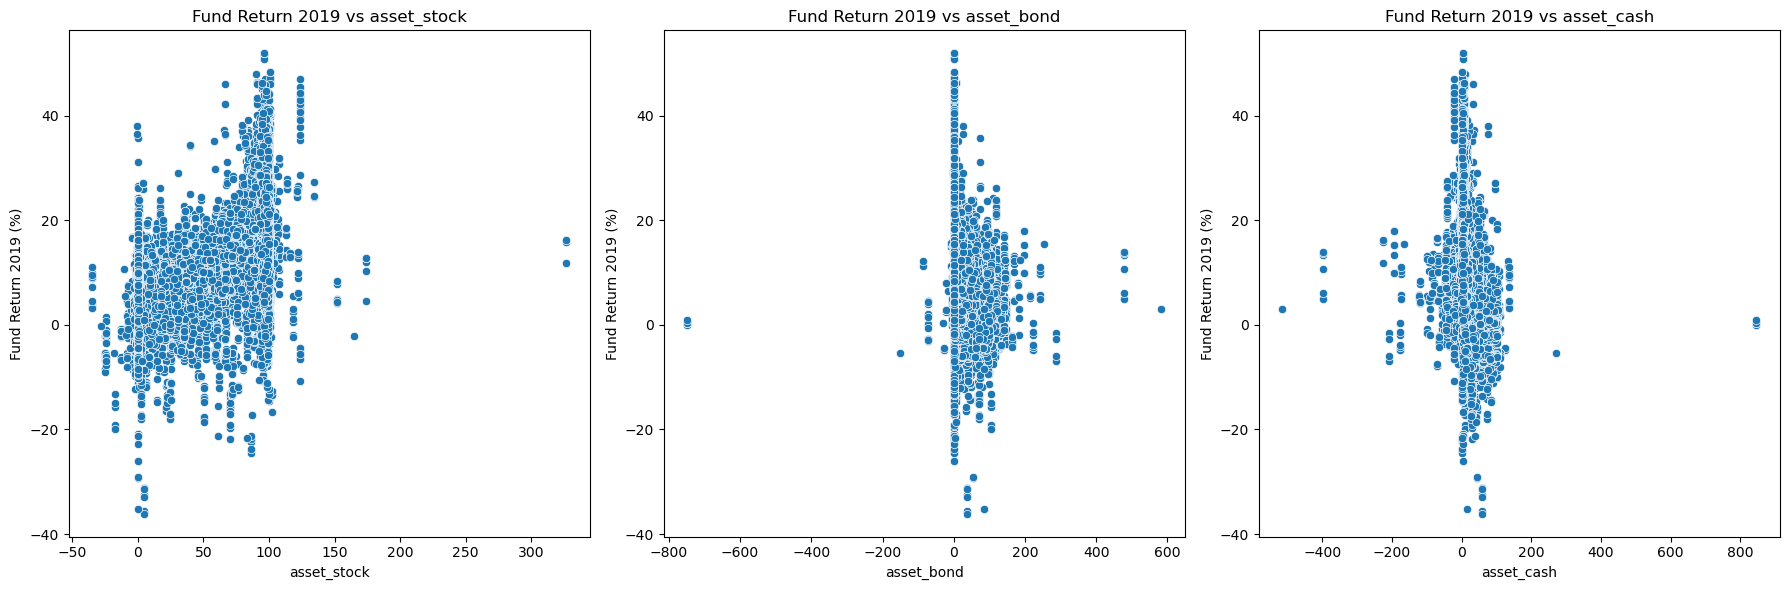

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
asset_allocation_columns = ['asset_stock', 'asset_bond', 'asset_cash']

# Check if the relevant columns exist in the DataFrame
if all(column in m.columns for column in asset_allocation_columns + ['fund_return_2019']):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Creating scatter plots for each asset allocation column
    for i, column in enumerate(asset_allocation_columns):
        sns.scatterplot(x=column, y='fund_return_2019', data=m, ax=axes[i])
        axes[i].set_title(f'Fund Return 2019 vs {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Fund Return 2019 (%)')

    plt.tight_layout()
    plt.show()
else:
    print('Some specified columns are missing from the DataFrame.')


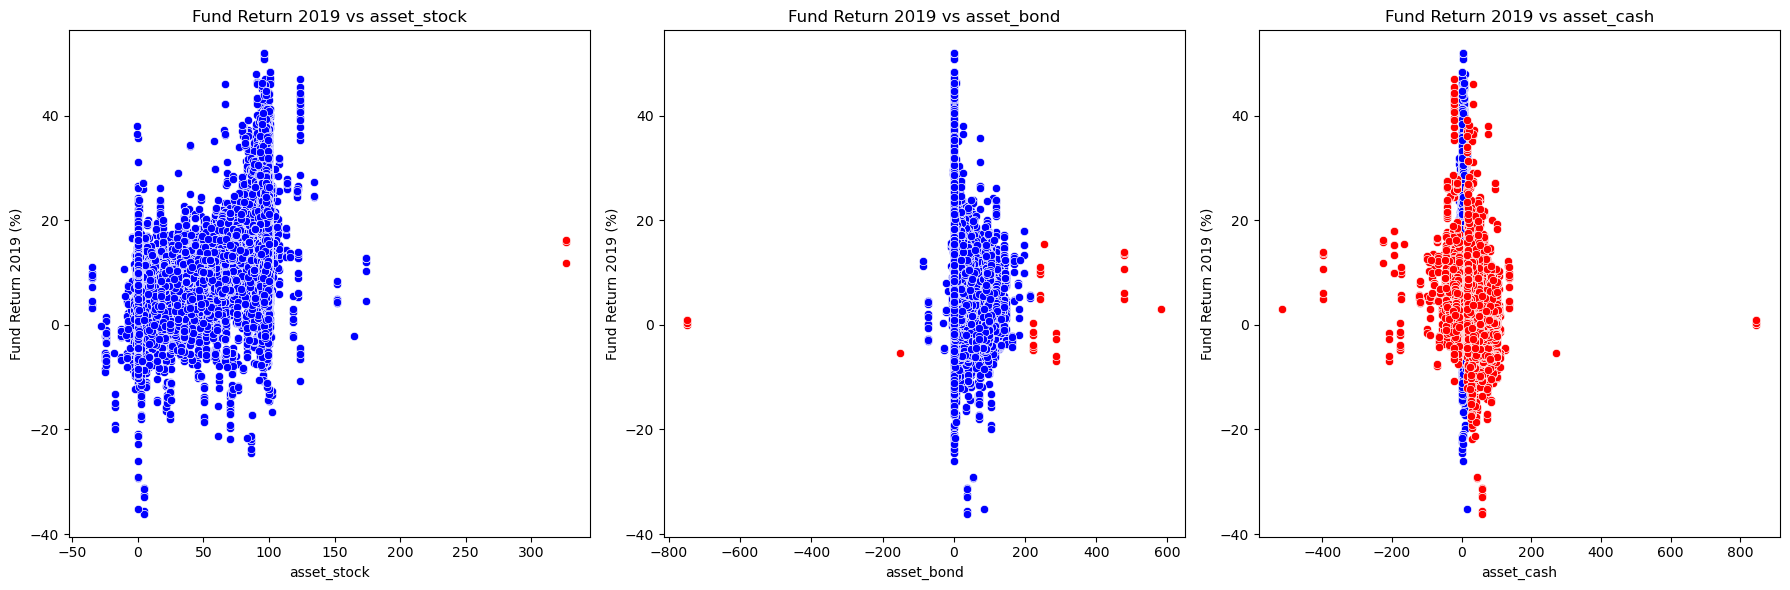

In [20]:
# Asset allocation columns
asset_allocation_columns = ['asset_stock', 'asset_bond', 'asset_cash']

# Check if the relevant columns exist in the DataFrame
if all(column in m.columns for column in asset_allocation_columns + ['fund_return_2019']):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Creating scatter plots for each asset allocation column and marking outliers
    for i, column in enumerate(asset_allocation_columns):
        # Calculate the IQR (Interquartile Range) to identify outliers
        Q1 = m[column].quantile(0.25)
        Q3 = m[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifying outliers
        outliers = (m[column] < lower_bound) | (m[column] > upper_bound)

        # Scatter plot without outliers
        sns.scatterplot(x=m[~outliers][column], y=m[~outliers]['fund_return_2019'], ax=axes[i], color='blue')

        # Scatter plot for outliers
        sns.scatterplot(x=m[outliers][column], y=m[outliers]['fund_return_2019'], ax=axes[i], color='red')

        axes[i].set_title(f'Fund Return 2019 vs {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Fund Return 2019 (%)')

    plt.tight_layout()
    plt.show()
else:
    print('Some specified columns are missing from the DataFrame.')

This analysis will help understand how the NAV per share, share class size, and fund size relate to the fund return in 2019:

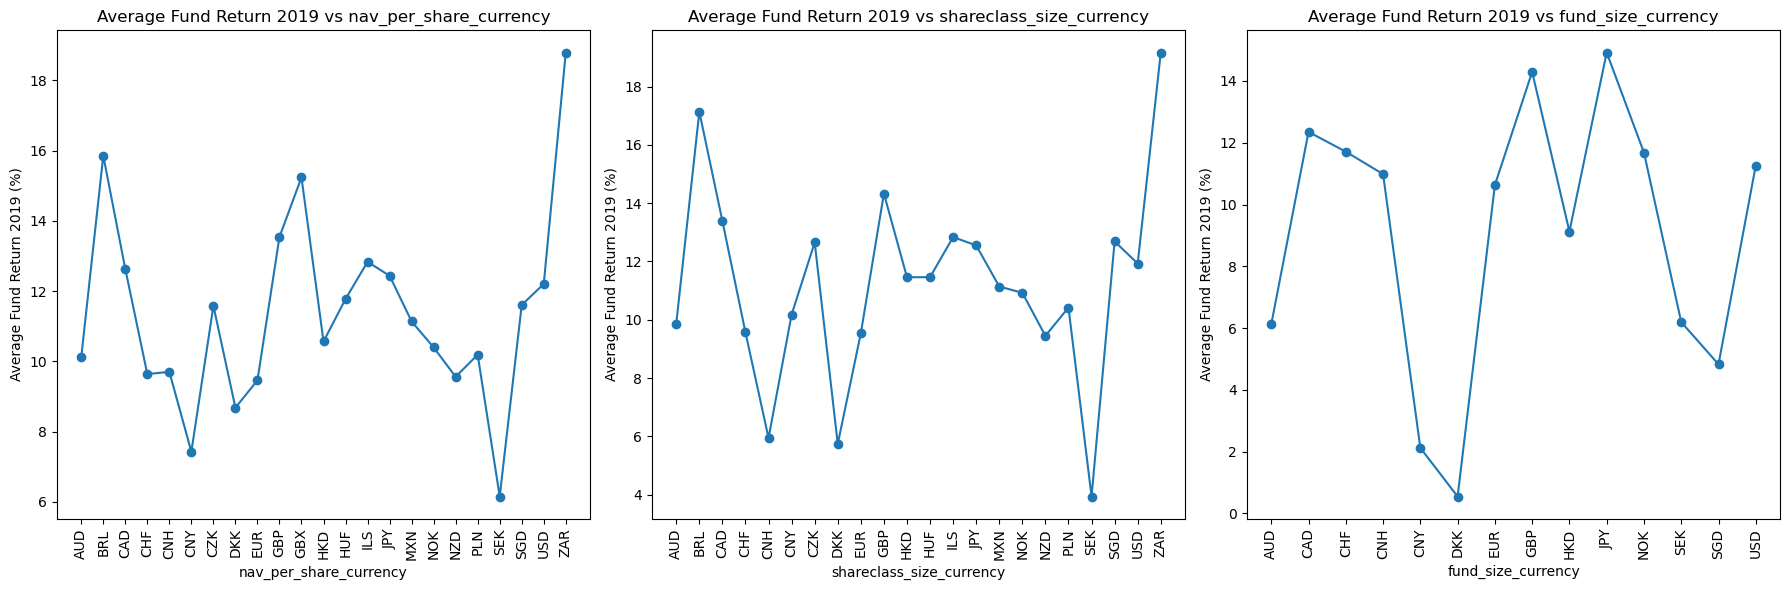

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is your DataFrame
categorical_nav_size_columns = ['nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency']

# Check if the relevant columns exist in the DataFrame
if all(column in df.columns for column in categorical_nav_size_columns + ['fund_return_2019']):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Creating line plots for each categorical NAV and size related column
    for i, column in enumerate(categorical_nav_size_columns):
        # Grouping the data by the categorical column and calculating mean fund return for each group
        grouped_data = df.groupby(column)['fund_return_2019'].mean().sort_index()

        # Plotting
        axes[i].plot(grouped_data.index, grouped_data.values, marker='o')
        axes[i].set_title(f'Average Fund Return 2019 vs {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Average Fund Return 2019 (%)')
        axes[i].tick_params(axis='x', rotation=90)  # Rotating x-axis labels

    plt.tight_layout()
    plt.show()
else:
    print('Some specified columns are missing from the DataFrame.')


whether funds denominated in a particular currency tend to have higher returns, 

# Modelling

In [27]:
sec_nan = m["long_term_projected_earnings_growth"].isna().mean() * 100
sec_nan

35.182195371768834

In [29]:
sec_nan = m["price_prospective_earnings"].isna().mean()*100
sec_nan

33.289932815999165

In [30]:
sec_nan = m["sales_growth"].isna().mean()*100
sec_nan

33.16146728469003

In [31]:
sec_nan = m["nav_per_share"].isna().mean()*100
sec_nan

0.0

In [32]:
numerical_cols

Index(['asset_stock', 'asset_bond', 'asset_cash', 'asset_other',
       'ongoing_cost', 'management_fees', 'involvement_abortive_contraceptive',
       'involvement_alcohol', 'involvement_animal_testing',
       'involvement_controversial_weapons', 'involvement_gambling',
       'involvement_gmo', 'involvement_military_contracting',
       'involvement_nuclear', 'involvement_palm_oil', 'involvement_pesticides',
       'involvement_small_arms', 'involvement_thermal_coal',
       'involvement_tobacco', 'nav_per_share', 'shareclass_size', 'fund_size',
       'fund_trailing_return_ytd', 'fund_trailing_return_3years',
       'fund_return_2019', 'fund_return_2018', 'fund_return_2020_q3',
       'fund_return_2020_q2', 'fund_return_2020_q1', 'fund_return_2019_q4',
       'fund_return_2019_q3', 'fund_return_2019_q2', 'fund_return_2019_q1',
       'fund_return_2018_q4', 'fund_return_2018_q3', 'fund_return_2018_q2',
       'fund_return_2018_q1', 'fund_return_2017_q4', 'fund_return_2017_q3',
     

In [35]:
categorical_cols

Index(['ticker', 'isin', 'fund_name', 'inception_date', 'category',
       'investment_strategy', 'investment_managers', 'fund_benchmark',
       'morningstar_benchmark', 'country_exposure', 'latest_nav_date',
       'nav_per_share_currency', 'shareclass_size_currency',
       'fund_size_currency', 'top5_holdings'],
      dtype='object')

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming df is your DataFrame

# Specified numerical columns
num_cols_nav = [
    'asset_stock', 'asset_bond', 'asset_cash', 'asset_other', 'ongoing_cost', 
    'management_fees', 'involvement_abortive_contraceptive', 'involvement_alcohol', 
    'involvement_animal_testing', 'involvement_controversial_weapons', 
    'involvement_gambling', 'involvement_gmo', 'involvement_military_contracting',
    'involvement_nuclear', 'involvement_palm_oil', 'involvement_pesticides',
    'involvement_small_arms', 'involvement_thermal_coal', 'involvement_tobacco', 
    'shareclass_size', 'fund_size', 'fund_trailing_return_ytd', 
    'fund_trailing_return_3years', 'fund_return_2018_q4', 'fund_return_2018_q3', 
    'fund_return_2018_q2', 'fund_return_2018_q1', 'fund_return_2017_q4', 
    'fund_return_2017_q3', 'fund_return_2017_q2', 'fund_return_2017_q1', 
    'quarters_up', 'quarters_down'
]

# Specified categorical columns
cat_cols_nav = [
    'inception_date', 'category', 'investment_strategy', 'investment_managers', 
    'fund_benchmark', 'morningstar_benchmark', 'country_exposure', 'latest_nav_date', 
    'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency', 'top5_holdings'
]

# Selecting only the specified columns
df_selected = m[num_cols_nav + cat_cols_nav + ['nav_per_share']]

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_selected, columns=cat_cols_nav)

# Define the target variable and the features
target = 'nav_per_share'
features = [col for col in df_encoded.columns if col != target]

X = df_encoded[features]
y = df_encoded[target]

# Handling missing values (if any)
X.fillna(X.mean(), inplace=True)

# Train the RandomForest Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions and model evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


/var/folders/6m/0w40n7p11jd2c0112ngdmyx40000gn/T/ipykernel_46358/290877007.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


KeyboardInterrupt: 

# Grid search

In [ ]:
# One-hot encode categorical variables
# Specified categorical columns
cat_cols_nav = [ 'category', 'investment_strategy', 'investment_managers', 
    'fund_benchmark', 'morningstar_benchmark', 'country_exposure', 'latest_nav_date', 
    'nav_per_share_currency', 'shareclass_size_currency', 'fund_size_currency'
]
cols_fr_rf = ['asset_stock', 'asset_bond', 'involvement_abortive_contraceptive', 'involvement_animal_testing', 'fund_trailing_return_3years', 'fund_return_2018_q4', 'fund_return_2018_q2', 'fund_return_2017_q4', 'fund_return_2017_q3', 'fund_return_2017_q1']
#df_encoded = pd.get_dummies(df_selected_2, columns=cat_cols_nav)

# Define the target variable and the features
target = 'fund_return_2019'
#features = [col for col in df_encoded.columns if col != target]

X = df[cols_fr_rf]
y = df[target]

# Handling missing values (if any)
#X.fillna(X.mean(), inplace=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
}

# Create a RandomForestRegressor model
rf = RandomForestRegressor()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming df is your DataFrame

# Specified numerical columns
cols_fr_rf = ['asset_stock', 'asset_bond', 'involvement_abortive_contraceptive', 'involvement_animal_testing', 'fund_trailing_return_3years', 'fund_return_2018_q4', 'fund_return_2018_q2', 'fund_return_2017_q4', 'fund_return_2017_q3', 'fund_return_2017_q1']



# Define the target variable and the features
target = 'fund_return_2019'

X = df[cols_fr_rf]
y = df[target]

# Handling missing values (if any)
X.fillna(X.mean(), inplace=True)

# Train the RandomForest Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions and model evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')



/var/folders/6m/0w40n7p11jd2c0112ngdmyx40000gn/T/ipykernel_46358/3859816187.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
/var/folders/6m/0w40n7p11jd2c0112ngdmyx40000gn/T/ipykernel_46358/3859816187.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
/var/folders/6m/0w40n7p11jd2c0112ngdmyx40000gn/T/ipykernel_46358/3859816187.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

Mean Squared Error: 6.78430520097892
R² Score: 0.9155706219657613


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Assuming df is your DataFrame

# Specified numerical columns
cols_fr_rf = [
    'asset_stock', 'asset_bond', 'asset_cash', 'asset_other', 'ongoing_cost', 
    'management_fees', 'involvement_abortive_contraceptive', 'involvement_alcohol', 
    'involvement_animal_testing', 'involvement_controversial_weapons', 
    'involvement_gambling', 'involvement_gmo', 'involvement_military_contracting',
    'involvement_nuclear', 'involvement_palm_oil', 'involvement_pesticides',
    'involvement_small_arms', 'involvement_thermal_coal', 'involvement_tobacco', 
    'shareclass_size', 'fund_size', 'fund_trailing_return_ytd', 
    'fund_trailing_return_3years', 'fund_return_2018_q4', 'fund_return_2018_q3', 
    'fund_return_2018_q2', 'fund_return_2018_q1', 'fund_return_2017_q4', 
    'fund_return_2017_q3', 'fund_return_2017_q2', 'fund_return_2017_q1', 
    'quarters_up', 'quarters_down','nav_per_share',
]


# Define the target variable and the features
target = 'fund_return_2019'

X = df[cols_fr_rf]
y = df[target]

# Handling missing values (if any)
X.fillna(X.mean(), inplace=True)

# Train the RandomForest Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predictions and model evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')




/var/folders/6m/0w40n7p11jd2c0112ngdmyx40000gn/T/ipykernel_46358/994322119.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Mean Squared Error: 4.073322544474462
R² Score: 0.9493082815741842


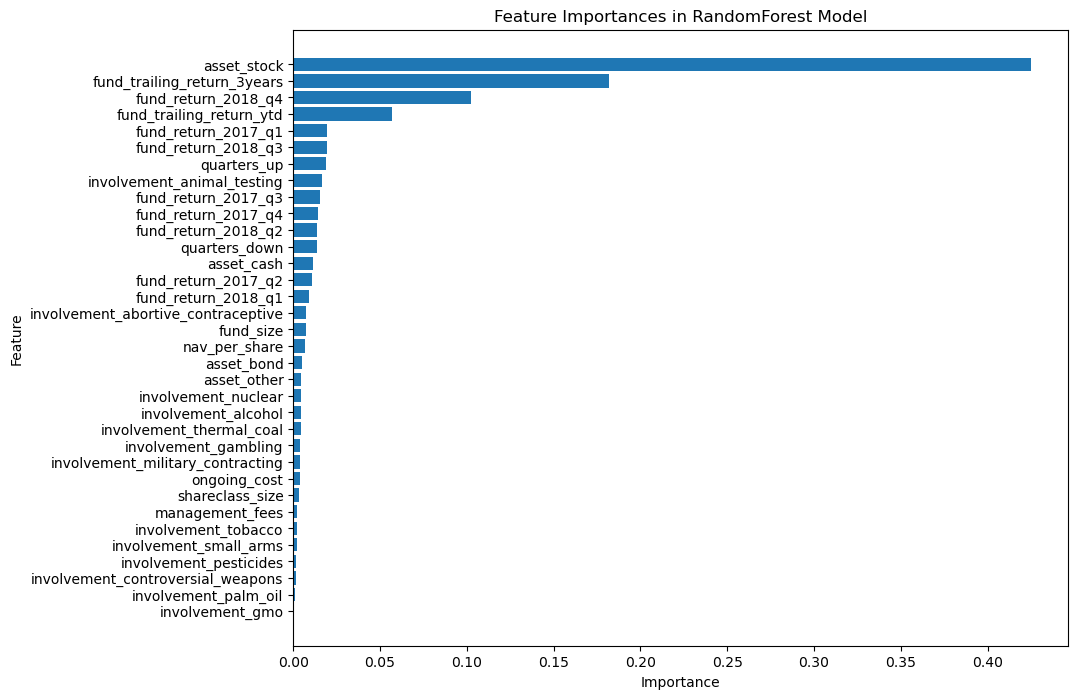

In [40]:
feature_importances = model.feature_importances_

# Converting to a more readable format
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Visualizing feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances in RandomForest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()